<a href="https://colab.research.google.com/github/teohteiktoe/Bankruptcy-Keras/blob/main/Mapreduce_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Hadoop and run mapreduce

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -nc -q https://downloads.apache.org/hadoop/common/hadoop-3.3.1/hadoop-3.3.1.tar.gz > /dev/null
!tar -xzf /content/hadoop-3.3.1.tar.gz
#Copy  hadoop file to user/local
!cp -r /content/hadoop-3.3.1/ /usr/local/
#To find the default Java path
!readlink -f /usr/bin/java | sed "s:bin/java::"
!sed -i 's@# export JAVA_HOME=@export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64@g' /usr/local/hadoop-3.3.1/etc/hadoop/hadoop-env.sh
#Verify java home is set properly
!cat /usr/local/hadoop-3.3.1/etc/hadoop/hadoop-env.sh | grep JAVA_HOME
!if [ $(/usr/local/hadoop-3.3.1/bin/hadoop | grep "Usage" | wc -l ) -eq 1 ]; then echo "installation of hadoop is ok...."; else echo "installation has problem. please rerun"; fi

## Check mapreduce can run locally

In [ ]:
!mkdir /content/input
!cp /usr/local/hadoop-3.3.1/etc/hadoop/*.xml /content/input
!ls /content/input

## Running MR example

In [ ]:
!/usr/local/hadoop-3.3.1/bin/hadoop jar /usr/local/hadoop-3.3.1/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.1.jar grep /content/input /content/grep_example 'allowed[.]*'


In [ ]:
!cat /content/grep_example/*

## Clone mapper and reducer from teoh teik toe github

- https://github.com/teohteiktoe/mapreduce_colab

In [ ]:
%%writefile /content/mapper.py
#!/usr/bin/env python3

# import sys because we need to read and write data to STDIN and STDOUT
import sys

# reading entire line from STDIN (standard input)
for line in sys.stdin:
    # to remove leading and trailing whitespace
    line = line.strip()
    # split the line into words
    words = line.split()

    # we are looping over the words array and printing the word
    # with the count of 1 to the STDOUT
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        print(word, 1)

In [ ]:
%%writefile /content/reducer.py

#!/usr/bin/env python

from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

# read the entire line from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # splitting the data on the basis of tab we have provided in mapper.py
    word, count = line.split(' ', 1)
    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to STDOUT
            print(current_word, current_count)
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print(current_word, current_count)

In [ ]:
%%writefile /content/example_text.txt
The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog.


Mapper output

In [ ]:
!cat /content/example_text.txt | python /content/mapper.py | head -10

Mapper + Reducer output

In [ ]:
!cat /content/example_text.txt | python /content/mapper.py| sort | python /content/reducer.py| sort -rn -t$'\t' -k2 | head -10

Top 10 word count from above. we have verified our script can work locally. let's try it on mapreduce

In [ ]:
!find / -name 'hadoop-streaming*.jar'
!chmod u+rwx /content/mapper.py
!chmod u+rwx /content/reducer.py
!rm -rf /content/output
!/usr/local/hadoop-3.3.1/bin/hadoop jar /usr/local/hadoop-3.3.1/share/hadoop/tools/lib/hadoop-streaming-3.3.1.jar -input /content/example_text.txt -output /content/output -file /content/mapper.py  -file /content/reducer.py  -mapper 'python mapper.py'  -reducer 'python reducer.py'


In [ ]:
!ls /content/output

In [ ]:
!cat /content/output/part-00000 | sort -rn -t$'\t' -k2 | head

# Install HDFS and RM and cluster dependencies

## RM / HDFS pseudo cluster mode needs SSH server

In [ ]:

#It is good practice to purge before installation
!apt-get purge openssh-server -qq
#Installing openssh-server
!apt-get install openssh-server -qq > /dev/null
#Starting the server
!service ssh start

!grep Port /etc/ssh/sshd_config
#Creating a new rsa key pair with empty password
!ssh-keygen -t rsa -P "" -f ~/.ssh/id_rsa
#Showing the public key
!more /root/.ssh/id_rsa.pub
#Copying the key to autorized keys
!cat $HOME/.ssh/id_rsa.pub>>$HOME/.ssh/authorized_keys
#Changing the permissions on the key
!chmod 0600 ~/.ssh/authorized_keys
#Conneting with the local machine
!ssh -o StrictHostKeyChecking=no localhost uptime


**you should see this. remember to click continue if you are stuck**

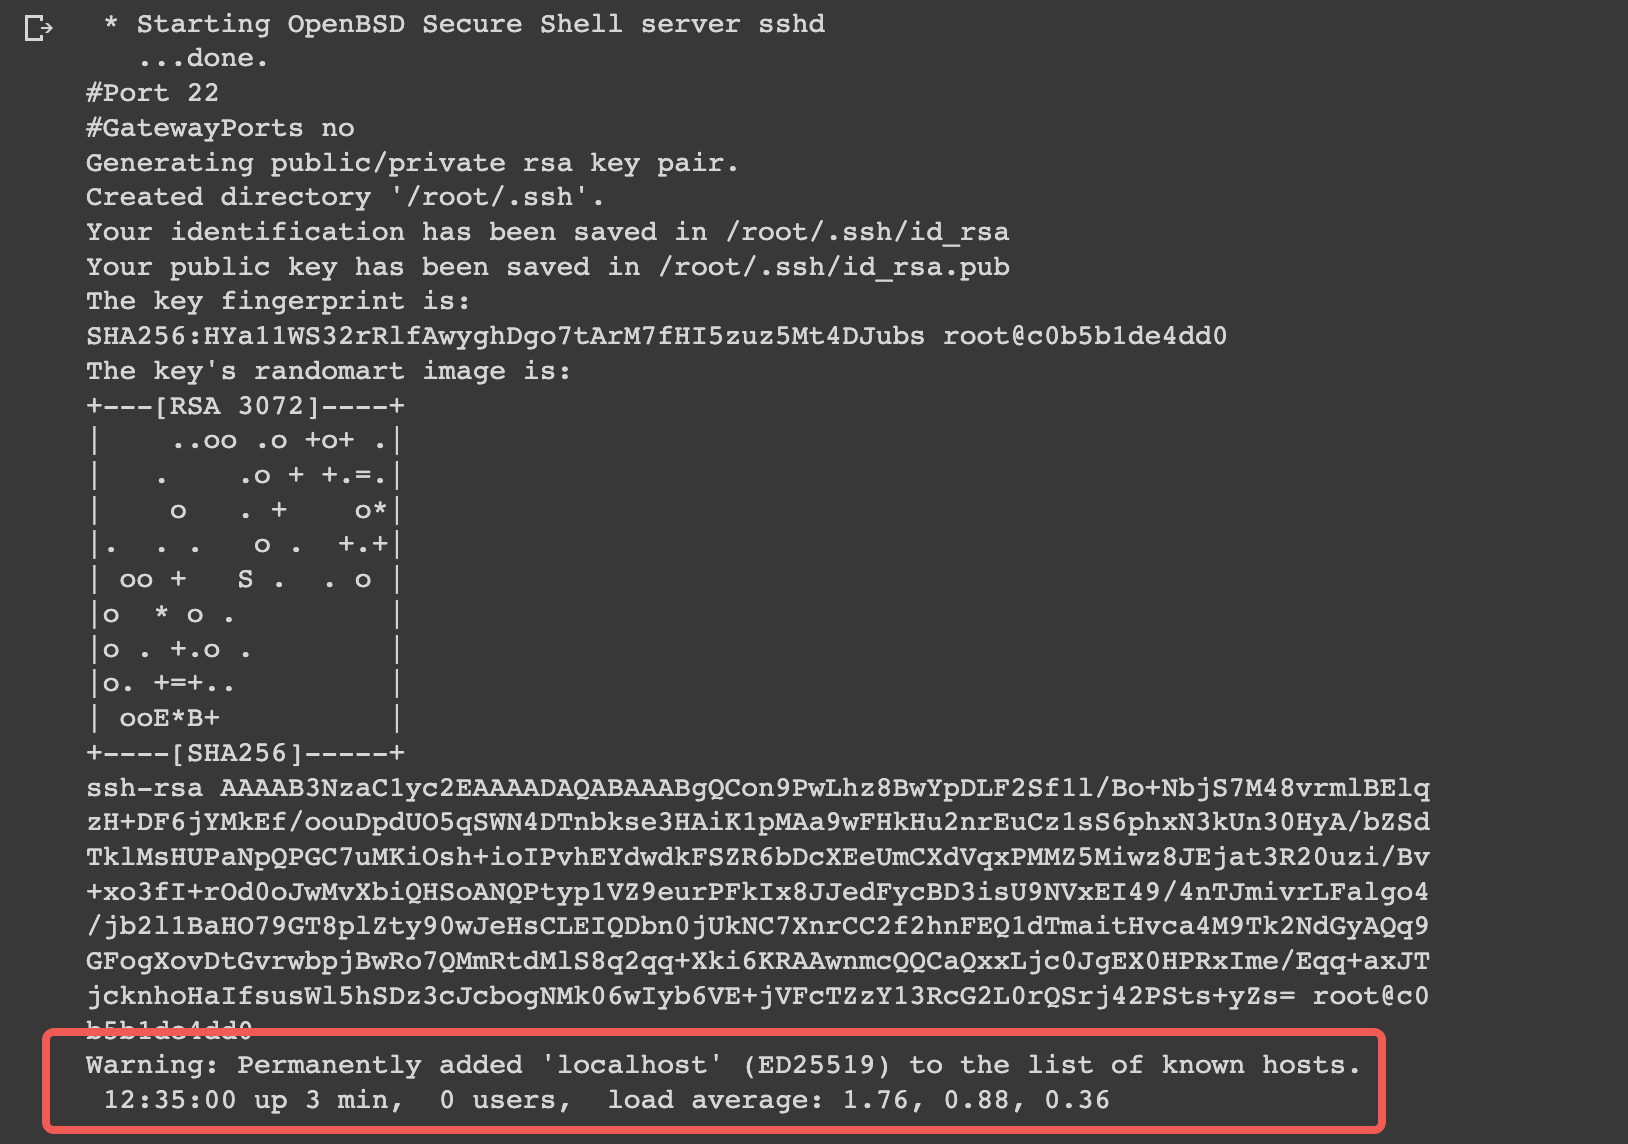

## Modify yarn config (please click run directly)

In [ ]:
import os
os.environ["HADOOP_HOME"] = "/usr/local/hadoop-3.3.1"

In [ ]:
!sed -i '/<configuration>/a\
  <property>\n\
    <name>fs.defaultFS</name>\n\
    <value>hdfs://localhost:9000</value>\n\
  </property>' \
$HADOOP_HOME/etc/hadoop/core-site.xml

!cat $HADOOP_HOME/etc/hadoop/core-site.xml

In [ ]:
#Adding required property to hdfs-site.xml file
#Since we are running Hadoop in only one machine, a replication factor greater than 1 does not make sense
!sed -i '/<configuration>/a\
  <property>\n\
    <name>dfs.replication</name>\n\
    <value>1</value>\n\
  </property>' \
$HADOOP_HOME/etc/hadoop/hdfs-site.xml
#Content of hdfs-site.xml after the editing
!cat $HADOOP_HOME/etc/hadoop/hdfs-site.xml

In [ ]:
#Adding required properties to mapred-site.xml file
!sed -i '/<configuration>/a\
  <property>\n\
    <name>mapreduce.framework.name</name>\n\
    <value>yarn</value>\n\
  </property>\n\
  <property>\n\
    <name>mapreduce.application.classpath</name>\n\
    <value>$HADOOP_MAPRED_HOME/share/hadoop/mapreduce/*:$HADOOP_MAPRED_HOME/share/hadoop/mapreduce/lib/*</value>\n\
  </property>' \
$HADOOP_HOME/etc/hadoop/mapred-site.xml
#Content of mapred-site.xml after the editing
!cat $HADOOP_HOME/etc/hadoop/mapred-site.xml

In [ ]:
#Adding required properties to yarn-site.xml file
!sed -i '/<configuration>/a\
  <property>\n\
    <description>The hostname of the RM.</description>\n\
    <name>yarn.resourcemanager.hostname</name>\n\
    <value>localhost</value>\n\
  </property>\n\
  <property>\n\
    <name>yarn.nodemanager.aux-services</name>\n\
    <value>mapreduce_shuffle</value>\n\
  </property>\n\
  <property>\n\
    <name>yarn.nodemanager.env-whitelist</name>\n\
    <value>JAVA_HOME,HADOOP_COMMON_HOME,HADOOP_HDFS_HOME,HADOOP_CONF_DIR,CLASSPATH_PREPEND_DISTCACHE,HADOOP_YARN_HOME,HADOOP_HOME,PATH,LANG,TZ,HADOOP_MAPRED_HOME</value>\n\
  </property>' \
$HADOOP_HOME/etc/hadoop/yarn-site.xml
#Content of yarn-site.xml after the editing
!cat $HADOOP_HOME/etc/hadoop/yarn-site.xml

## Format namenode for hdfs

In [ ]:
!$HADOOP_HOME/bin/hdfs namenode -format

## Add env variable for RM and HDFS

In [ ]:
#Exploring Hadoop scripts available in sbin directory
!ls $HADOOP_HOME/sbin
#Creating other necessary enviroment variables before starting nodes
import os
os.environ["HDFS_NAMENODE_USER"] = "root"
os.environ["HDFS_DATANODE_USER"] = "root"
os.environ["HDFS_SECONDARYNAMENODE_USER"] = "root"
os.environ["YARN_RESOURCEMANAGER_USER"] = "root"
os.environ["YARN_NODEMANAGER_USER"] = "root"

!printenv | grep -i hdfs | grep root | wc -l # return 3
!printenv | grep -i yarn | grep root | wc -l # return 2

In [ ]:
#Launching hdfs deamons
!$HADOOP_HOME/sbin/start-dfs.sh
#Launching yarn deamons
#nohup causes a process to ignore a SIGHUP signal
!nohup $HADOOP_HOME/sbin/start-yarn.sh
#Listing the running deamons
!jps
#should return RM / datanode / Sec datanode

In [ ]:
#Report the basic file system information and statistics
!$HADOOP_HOME/bin/hdfs dfsadmin -report

In [ ]:
!$HADOOP_HOME/bin/hdfs dfs -mkdir /word_count_with_python
#Copying the file from local file system to Hadoop distributed file system (HDFS)
!$HADOOP_HOME/bin/hdfs dfs -put /content/example_text.txt /word_count_with_python

#Exploring Hadoop folder
!$HADOOP_HOME/bin/hdfs dfs -ls /word_count_with_python

In [ ]:
#Running MapReduce programs
!$HADOOP_HOME/bin/hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-3.3.1.jar \
  -input /word_count_with_python/example_text.txt \
  -output /word_count_with_python/output10 \
  -mapper "python /content/mapper.py" \
  -reducer "python /content/reducer.py"

In [ ]:
!$HADOOP_HOME/bin/hdfs dfs -ls /word_count_with_python/output10


!$HADOOP_HOME/bin/hdfs dfs -cat /word_count_with_python/output10/part-00000 | head -50


In [ ]:
!$HADOOP_HOME/bin/hdfs dfs -cat /word_count_with_python/output10/part-00000 | sort -rn -t$'\t' -k2 | head